In [43]:
from scipy.integrate import quad
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pywt
import pandas as pd


In [44]:
file_name = 'CH4 954 ppm raw/00'
df_01 = pd.read_csv(file_name, delim_whitespace=True, quotechar="\"") 
# print(df_01)


for i in range(1,100):
    ind = i if i>=10 else f"0{i}"
    file_name = f"CH4 954 ppm raw/{ind}" # в каждом файле записано 2 секунды
    df = pd.read_csv(file_name, delim_whitespace=True, quotechar="\"")
    df_01 = pd.concat([df_01, df], ignore_index=True)
print(df_01)


             x           y0          y1        y2          y3
0            0  820507000.0 -14444500.0 -227840.0 -13735900.0
1            1  859676000.0  -6947580.0 -219392.0 -12532000.0
2            2  833578000.0    829952.0 -211968.0 -13924400.0
3            3  905413000.0   8641790.0 -206080.0 -16608000.0
4            4  806905000.0  15951100.0 -196608.0 -16278500.0
...        ...          ...         ...       ...         ...
9599995  95995  702471000.0 -23103000.0 -188928.0 -11244300.0
9599996  95996  786943000.0 -16965100.0 -192512.0 -13622000.0
9599997  95997  834429000.0  -9716480.0 -176128.0 -12947500.0
9599998  95998  827305000.0  -1933570.0 -163840.0 -12815100.0
9599999  95999  863073000.0   5976830.0 -177408.0 -15446000.0

[9600000 rows x 5 columns]


$$Wavelet\ Pyro$$

In [48]:
# Size_pyro = 9_600_000
Size_pyro = 9_600_000

sst_pyro  = df_01.y0.iloc[:Size_pyro]
df_01.x = df_01.index
time = df_01.x.iloc[:Size_pyro]

dt = 1.0/48_000

# wavelet = 'gaus1'
# max_scale = 5.65
# min_scale = 5.25

# wavelet = 'mexh'
# max_scale = 6.9
# min_scale = 6.5


# wavelet = 'gaus3'
# max_scale = 11.2
# min_scale = 10.5


# wavelet = 'gaus4'
# max_scale = 14.1
# min_scale = 13

# wavelet = 'morl'
# max_scale = 23
# min_scale = 21



# wavelet = 'cmor10-1792'
# max_scale = 49
# min_scale = 46

# wavelet = 'cmor1-1792'
# max_scale = 47.7
# min_scale = 46.3

wavelet = 'cmor1-1778'
max_scale = 350
min_scale = 320



scales = np.arange(min_scale, max_scale, 2)

slase = 95750
size_shape = 500

delta_time = 48000
interval = int(Size_pyro/delta_time)




In [49]:
[cfs_pyro, frequencies] = pywt.cwt(sst_pyro, scales, wavelet, dt)

# print(len(cfs_pyro))
# print(len(cfs_pyro[0]))

period = 1.0/frequencies

print(frequencies)
# print(len(cfs_pyro))
# print(len(cfs_pyro[0]))



[1837.5        1826.08695652 1814.81481481 1803.6809816  1792.68292683
 1781.81818182 1771.08433735 1760.47904192 1750.         1739.64497041
 1729.41176471 1719.29824561 1709.30232558 1699.42196532 1689.65517241]


In [50]:
cfs_pyro = np.abs(cfs_pyro)

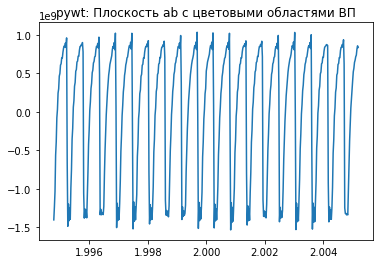

In [51]:
A_scales, B_time = np.meshgrid(time[slase:slase+size_shape]*dt, frequencies)


plt.figure('pywt: 2D-график для z = w (a,b)')
plt.title('pywt: Плоскость ab с цветовыми областями ВП', size=12)
plt.plot(time[slase:slase+size_shape]*dt, sst_pyro[slase:slase+size_shape])

plt.show()

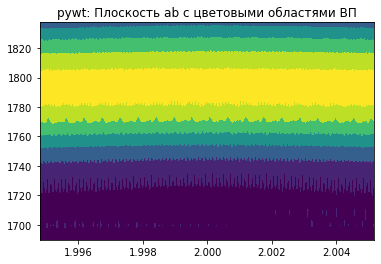

In [52]:
cfs_pyro_shape = np.array([cfs_pyro[i][slase:slase+size_shape] for i in range(len(scales))])
plt.figure('pywt: 2D-график для z = w (a,b)')
plt.title('pywt: Плоскость ab с цветовыми областями ВП', size=12)
# plt.contourf(A_scales, B_time, np.log(abs(cfs_pyro_shape)), 10)
plt.contourf(A_scales, B_time, cfs_pyro_shape, extend='both')
plt.show()

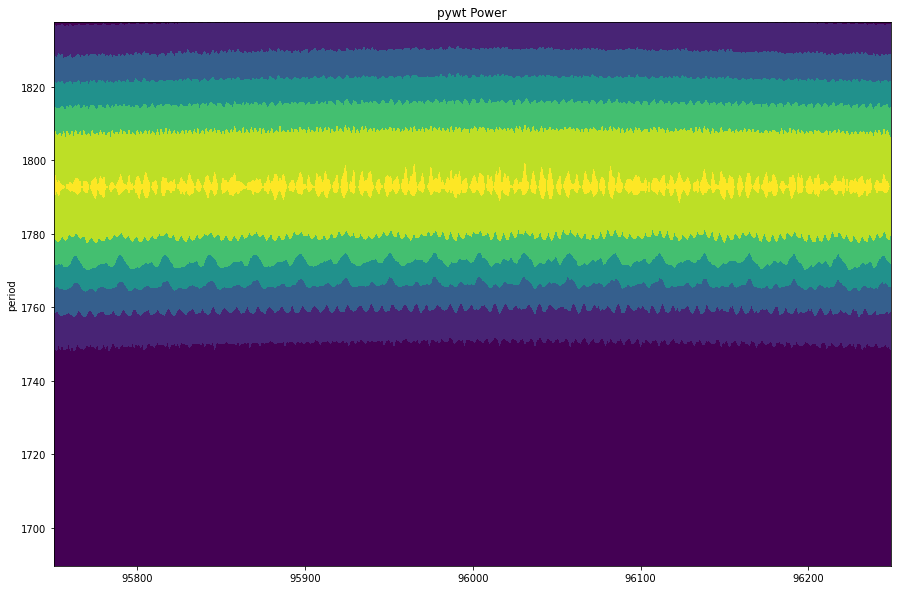

In [53]:
# power_pyro = (abs(cfs_pyro)) ** 2
# print(type(cfs_pyro))
# print(type(cfs_pyro_shape))
power_pyro_shape = (cfs_pyro_shape)**2

# # levels = [0.0625, 0.125, 0.25,]
f, ax = plt.subplots(figsize=(15, 10))
ax.contourf(time[slase:slase+size_shape], frequencies, power_pyro_shape, extend='both')

ax.set_title("pywt Power")
ax.set_ylabel('period')
plt.show()

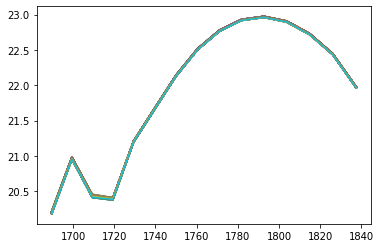

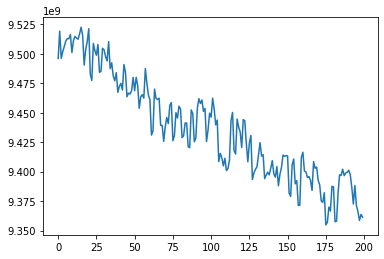

In [54]:
# power_pyro_tr = power_pyro.transpose()
power_pyro_tr = cfs_pyro.transpose()


# Amp_pyro = zeros((interval))
mean_pyro_scales = np.zeros((interval,int(len(scales))))


plt.figure('max_Amp')

Max_pyro_amp_scales = np.zeros((interval))

for j in range(0,interval,1):
    temp_pyro = power_pyro_tr[delta_time*j:delta_time*(j+1)].transpose()
    for i in range(len(scales)):
        mean_pyro_scales[j][i-1] = temp_pyro[i-1].mean()
    plt.plot(frequencies, np.log(mean_pyro_scales[j]))
    Max_pyro_amp_scales[j] = mean_pyro_scales[j].max()
plt.show()


plt.figure('Max_pyro')
plt.plot(Max_pyro_amp_scales)
plt.show()

$$Save\ \  Pyro\ \  in\ \  .csv$$

In [55]:
from pathlib import Path  

df_mean_pyro_scales = pd.DataFrame(mean_pyro_scales)
df_mean_pyro_scales.columns = period
# print(df_mean_pyro_scales)


filepath = Path('wt_raw/cmor_1_1778_pyro_954.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)

df_mean_pyro_scales.to_csv(filepath) 

# print(df_mean_pyro_scales)


$$KERNEL\ \  FALLED$$

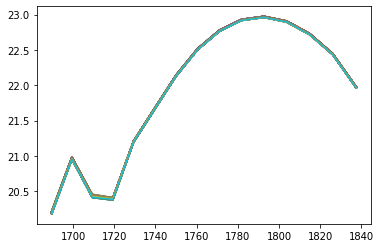

1792.6829268292684


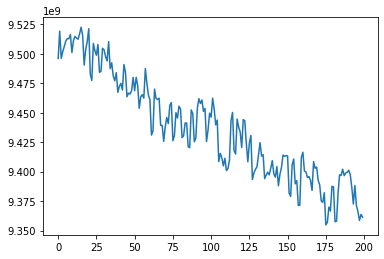

In [59]:
file_name_pyro = 'wt_raw/cmor_1_1778_pyro_954.csv'
df_pyro_Amp = pd.read_csv(file_name_pyro) 
df_pyro_Amp = df_pyro_Amp.drop('Unnamed: 0', axis = 1)


mean_pyro_scales = df_pyro_Amp.to_numpy()

period = np.array([float(str_j) for str_j in list(df_pyro_Amp.columns)])

frequencies = 1.0/period

plt.figure('max_Amp')
    
Max_pyro_amp_scales = np.zeros((interval))

for j in range(0,interval,1):
    plt.plot(frequencies, np.log(mean_pyro_scales[j]))
    Max_pyro_amp_scales[j] = mean_pyro_scales[j].max()
#     print(1.0/period[mean_pyro_scales[j].argmax()])
plt.show()

print(frequencies[mean_pyro_scales[1].argmax()])


plt.figure('Max_pyro')
plt.plot(Max_pyro_amp_scales)
plt.show()    


$$Wavelet \ OAD$$

-362936.39139625
23816573.175047703


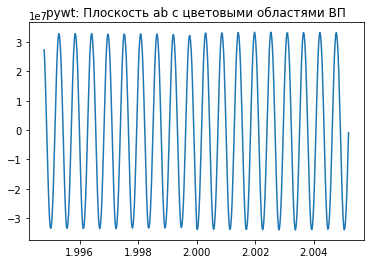

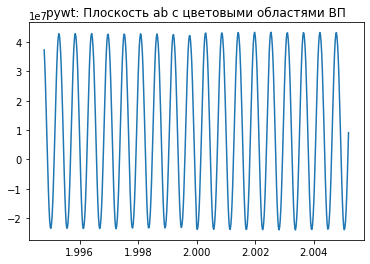

In [88]:
sst_oad  = df_01.y1.iloc[:Size_pyro]

print(sst_oad.mean())
print(sst_oad.std())

plt.figure('pywt: 2D-график для z = w (a,b)')
plt.title('pywt: Плоскость ab с цветовыми областями ВП', size=12)
plt.plot(time[slase:slase+size_shape]*dt, sst_oad[slase:slase+size_shape])

plt.show()

sst_oad = sst_oad + 1e7

plt.figure('pywt: 2D-график для z = w (a,b)')
plt.title('pywt: Плоскость ab с цветовыми областями ВП', size=12)
plt.plot(time[slase:slase+size_shape]*dt, sst_oad[slase:slase+size_shape])

plt.show()

In [ ]:
[cfs_oad, frequencies] = pywt.cwt(sst_oad, scales, wavelet, dt)

period = 1.0/frequencies

In [61]:
cfs_oad = np.abs(cfs_oad)
# cfs_oad_shape = array([cfs_oad[i-1][:size_shape] for i in scales])


In [84]:
A_scales, B_time = np.meshgrid(time[slase:slase+size_shape]*dt, period)
# A_scales, B_time = meshgrid(time[:size_shape],scales)

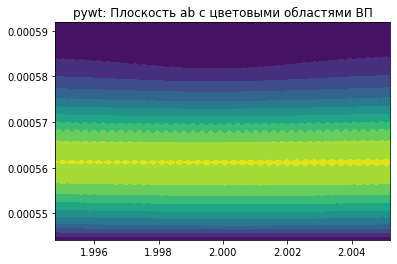

In [63]:
cfs_oad_shape = np.array([cfs_oad[i-1][slase:slase+size_shape] for i in range(len(scales))])
plt.figure('pywt: 2D-график для z = w (a,b)')
plt.title('pywt: Плоскость ab с цветовыми областями ВП', size=12)
# plt.contourf(A_scales, B_time, np.log(abs(cfs_oad_shape)), 10)
plt.contourf(A_scales, B_time, cfs_oad_shape, 10)
plt.show()

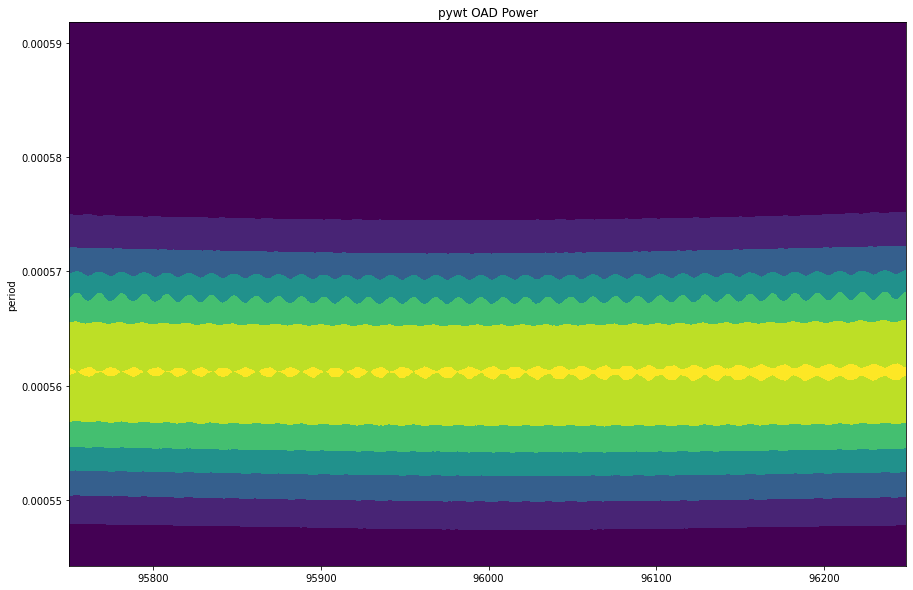

In [64]:
# power_oad = (abs(cfs_oad)) ** 2
power_oad_shape = (cfs_oad_shape)**2


period = 1. / frequencies
# levels = [0.0625, 0.125, 0.25,]
f, ax = plt.subplots(figsize=(15, 10))
ax.contourf(time[slase:slase+size_shape], period, power_oad_shape, extend='both')

ax.set_title("pywt OAD Power")
ax.set_ylabel('period')
plt.show()

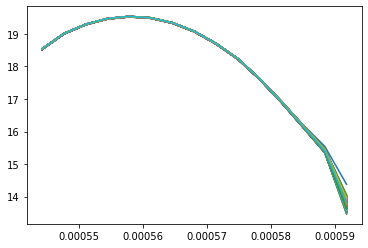

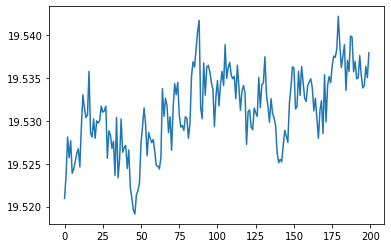

In [65]:
# power_oad_tr = power_oad.transpose()
power_oad_tr = cfs_oad.transpose()
# Amp_oad = zeros((interval))


mean_oad_scales = np.zeros((interval,int(len(scales))))

Max_oad_amp_scales = np.zeros((interval))

plt.figure('max_Amp')

for j in range(0,interval,1):
    temp_oad = power_oad_tr[delta_time*j:delta_time*(j+1)].transpose()
    for i in range(len(scales)):
        mean_oad_scales[j][i-1] = temp_oad[i-1].mean()
    plt.plot(period, np.log(mean_oad_scales[j]))
    Max_oad_amp_scales[j] = mean_oad_scales[j].max()
plt.show()

plt.figure('Max_oad')
plt.plot(np.log(Max_oad_amp_scales))
plt.show()

$$Save \ OAD \ to \ .csv$$

In [66]:
from pathlib import Path  

df_mean_oad_scales = pd.DataFrame(mean_oad_scales)
df_mean_oad_scales.columns = period
# print(df_mean_pyro_scales)


filepath = Path('wt_raw/cmor_1_1778_oad_954.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)

df_mean_oad_scales.to_csv(filepath) 

# print(df_mean_pyro_scales)

$$ KERNEL \ FALLED$$

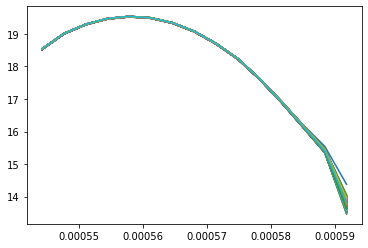

1792.6829268292684


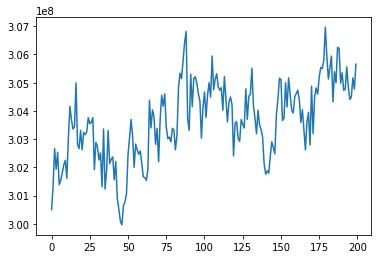

In [67]:
file_name_oad = 'wt_raw/cmor_1_1778_oad_954.csv'
df_oad_Amp = pd.read_csv(file_name_oad) 
df_oad_Amp = df_oad_Amp.drop('Unnamed: 0', axis = 1)


mean_oad_scales = df_oad_Amp.to_numpy()

period = np.array([float(str_j) for str_j in list(df_oad_Amp.columns)])

plt.figure('max_Amp')
    
Max_oad_amp_scales = np.zeros((interval))

for j in range(0,interval,1):
    plt.plot(period, np.log(mean_oad_scales[j]))
    Max_oad_amp_scales[j] = mean_oad_scales[j].max()
#     print(1.0/(period[mean_oad_scales[j].argmax()]))
plt.show()

# plt.plot(1.0 / period, np.log(mean_oad_scales[1]))
print(1.0/period[mean_oad_scales[1].argmax()])



plt.figure('Max_oad')
plt.plot(Max_oad_amp_scales)
plt.show()    



$$Wavelet \ \ \ OAD\ / \ Pyro$$

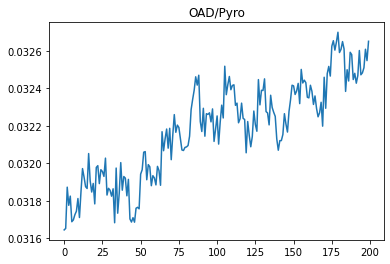

In [68]:
S_wavelet = Max_oad_amp_scales/Max_pyro_amp_scales
plt.figure('max_Amp')
plt.title('OAD/Pyro', size=12)
plt.plot(S_wavelet)
plt.show()

$$Fourier \ Transform$$

In [69]:
import numpy as np
import scipy.integrate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.optimize import curve_fit
import math

SAMPLE_RATE = 48000 #Hz
DURATION = 1 #sec
# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

min_freq = 1700
max_freq = 1800

max_intensity_OAD = np.zeros(200)
max_index_OAD = np.zeros(200)
max_intensity_Pyro = np.zeros(200)
max_index_Pyro = np.zeros(200)

for i in range(100):
    ind = i if i>=10 else f"0{i}"
    file_name = f"CH4 954 ppm raw/{ind}" # в каждом файле записано 2 секунды
    df = pd.read_csv(file_name, delim_whitespace=True, quotechar="\"") 

    Pyro = df.y0.values[0:SAMPLE_RATE]
    OAD = df.y1.values[0:SAMPLE_RATE]

    xf = rfftfreq(N, 1 / SAMPLE_RATE)
    Pyro_f = rfft(Pyro)
    OAD_f = rfft(OAD)

    max_intensity_OAD[2*i] = np.max(np.abs(OAD_f[min_freq:max_freq]))
    max_index_OAD[2*i] = np.argmax(np.abs(OAD_f[min_freq:max_freq]))
    max_intensity_Pyro[2*i] = np.max(np.abs(Pyro_f[min_freq:max_freq]))
    max_index_Pyro[2*i] = np.argmax(np.abs(Pyro_f[min_freq:max_freq]))

    Pyro = df.y0.values[SAMPLE_RATE:]
    OAD = df.y1.values[SAMPLE_RATE:]
    Pyro_f = rfft(Pyro)
    OAD_f = rfft(OAD)
    max_intensity_OAD[2*i+1] = np.max(np.abs(OAD_f[min_freq:max_freq]))
    max_index_OAD[2*i+1] = np.argmax(np.abs(OAD_f[min_freq:max_freq]))
    max_intensity_Pyro[2*i+1] = np.max(np.abs(Pyro_f[min_freq:max_freq]))
    max_index_Pyro[2*i+1] = np.argmax(np.abs(Pyro_f[min_freq:max_freq]))
#     print(xf[min_freq + np.argmax(np.abs(Pyro_f[min_freq:max_freq]))])
#     print(xf[min_freq + np.argmax(np.abs(OAD_f[min_freq:max_freq]))])

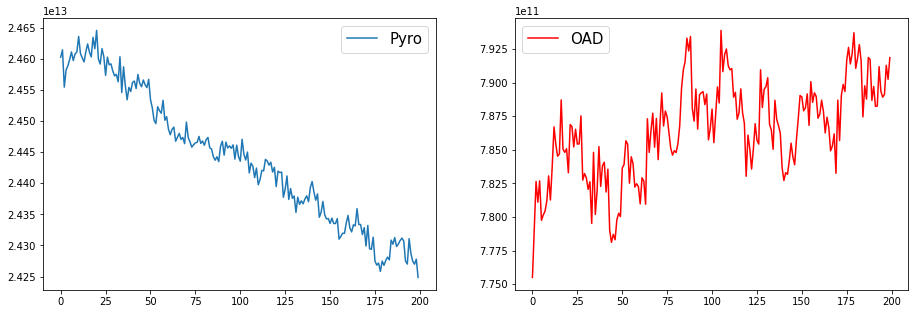

In [70]:
fig = plt.figure()
fig.set_size_inches(15.5, 5)
ax1 = fig.add_subplot(121)
ax1.plot([i for i in range(200)],max_intensity_Pyro, label='Pyro')
ax1.legend(prop={'size': 15})

ax2 = fig.add_subplot(122)
ax2.plot([i for i in range(200)],max_intensity_OAD, 'red', label='OAD')
ax2.legend(prop={'size': 15})


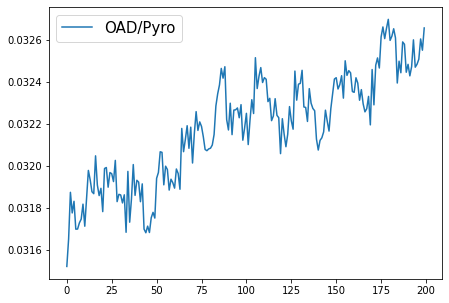

In [71]:
S_fourier = max_intensity_OAD/max_intensity_Pyro
fig = plt.figure()
fig.set_size_inches(15.5, 5)
ax1 = fig.add_subplot(121)
ax1.plot([i for i in range(200)],S_fourier, label='OAD/Pyro')
ax1.legend(prop={'size': 15})

# print(S_fourier.std()/S_fourier.mean())


# from scipy.optimize import curve_fit

# def func_theory(x, A, B):
#     return A + B*x


# x = np.arange(200)

# popt, pcov = curve_fit(func_theory, x, S_fourier)

# A_opt,B_opt = popt

# print(B_opt/S_fourier.mean()*100)


# d_S_f = S_fourier - func_theory(x,A_opt,B_opt)
# print(d_S_f.std()/S_fourier.mean()*100)



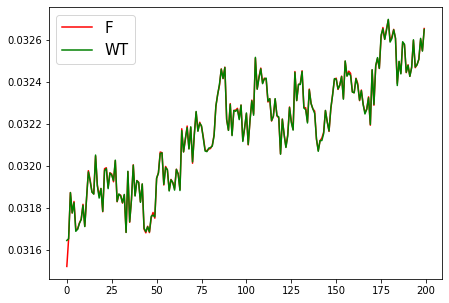

In [72]:
fig = plt.figure()
fig.set_size_inches(15.5, 5)
ax1 = fig.add_subplot(121)
ax1.plot([i for i in range(200)],S_fourier, label='F', color = 'red')
ax1.plot([i for i in range(200)],S_wavelet, label='WT', color = 'green')
ax1.legend(prop={'size': 15})

In [73]:
print(S_fourier.std()-S_wavelet.std())

1.3720187759946206e-06


In [74]:
print(S_fourier.std()/S_fourier.mean(), S_wavelet.std()/S_wavelet.mean())

0.008127999736340074 0.008085520495614597


In [75]:
print((S_fourier - S_wavelet).mean())

6.368517909962484e-07


In [77]:
print((S_fourier - S_wavelet).mean()/S_fourier.mean()*100)

0.00197919264275071


           x            y0          y1      y2          y3
0          0  5.274840e+08 -32779000.0 -171264   3549180.0
1          1  5.807320e+08 -33825000.0 -168960   2942720.0
2          2  6.446870e+08 -33116200.0 -170752  -1469440.0
3          3  6.795840e+08 -30837800.0 -154368  -8977410.0
4          4  7.147930e+08 -27103200.0 -172032 -10121500.0
...      ...           ...         ...     ...         ...
95995  95995 -1.380270e+09  33084200.0 -185856   1310720.0
95996  95996 -1.274260e+09  31452200.0 -173568   6033410.0
95997  95997 -1.363920e+09  28560400.0 -172288  10329300.0
95998  95998 -1.293970e+09  24231900.0 -174336   8512260.0
95999  95999 -1.089390e+09  18398200.0 -167680  16976400.0

[96000 rows x 5 columns]


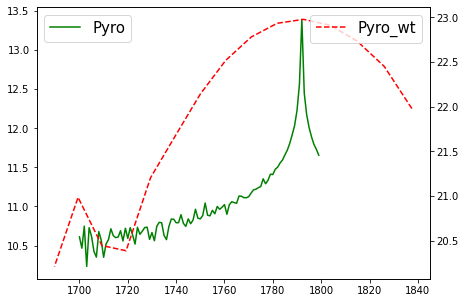

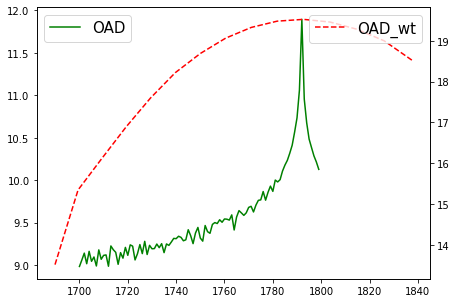

In [78]:
file_name = 'CH4 954 ppm raw/01'
df1 = pd.read_csv(file_name, delim_whitespace=True, quotechar="\"") 
print(df1)
SAMPLE_RATE = 48000 #Hz
DURATION = 1 #sec
# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

Pyro = df1.y0.values[:SAMPLE_RATE]
Pyro_f = rfft(Pyro)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

OAD = df1.y1.values[:SAMPLE_RATE]
OAD_f = rfft(OAD)

fig = plt.figure()
fig.set_size_inches(15.5, 5.0)
ax1 = fig.add_subplot(121)
ax2 = ax1.twinx()
ax1.plot(xf[min_freq:max_freq], np.log10(np.abs(Pyro_f[min_freq:max_freq])), 'green', label='Pyro')
ax2.plot(1.0 / period, np.log(mean_pyro_scales[1]), color='red', linestyle='--', label = 'Pyro_wt')

ax1.legend(prop={'size': 15},loc='upper left')
ax2.legend(prop={'size': 15},loc='upper right')


fig = plt.figure()
fig.set_size_inches(15.5, 5.0)
ax1 = fig.add_subplot(122)
ax2 = ax1.twinx()
ax1.plot(xf[min_freq:max_freq], np.log10(np.abs(OAD_f[min_freq:max_freq])), color='green', label='OAD')
ax2.plot(1.0 / period, np.log(mean_oad_scales[1]), color='red', linestyle='--', label = 'OAD_wt')

ax1.legend(prop={'size': 15},loc='upper left')
ax2.legend(prop={'size': 15},loc='upper right')




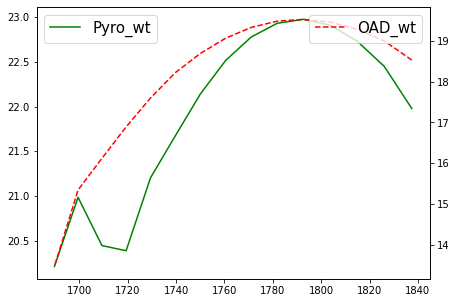

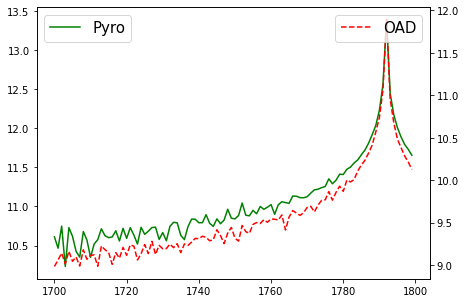

In [79]:
fig = plt.figure()
fig.set_size_inches(15.5, 5.0)
ax1 = fig.add_subplot(121)
ax2 = ax1.twinx()
ax1.plot(1.0 / period, np.log(mean_pyro_scales[1]), color='green', label = 'Pyro_wt')
ax2.plot(1.0 / period, np.log(mean_oad_scales[1]), color='red', linestyle='--', label = 'OAD_wt')

ax1.legend(prop={'size': 15},loc='upper left')
ax2.legend(prop={'size': 15},loc='upper right')




fig = plt.figure()
fig.set_size_inches(15.5, 5.0)
ax1 = fig.add_subplot(122)
ax2 = ax1.twinx()
ax1.plot(xf[min_freq:max_freq], np.log10(np.abs(Pyro_f[min_freq:max_freq])), 'green', label='Pyro')
ax2.plot(xf[min_freq:max_freq], np.log10(np.abs(OAD_f[min_freq:max_freq])), color='red', linestyle='--', label = 'OAD')

ax1.legend(prop={'size': 15},loc='upper left')
ax2.legend(prop={'size': 15},loc='upper right')